신경망 모델 작동 원리 알아보기

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor #이미 증강(Augmentation). ToTensor -> Torch Tensor로 만들어 주는 작업
from torch.utils.data import DataLoader # 모델에 데이터를 공급하는 역할

In [3]:
train_data = datasets.MNIST(
    root = 'data', #데이터를 저장할 root 디렉토리
    train = True, #훈련용 데이터 설정
    download = True,
    transform = ToTensor() #Transform : 이미지 증강 기법 지정, 여기서는 TorchTensor로 변환
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    download = True,
    transform = ToTensor() 
)


100%|██████████| 9912422/9912422 [00:00<00:00, 222684873.46it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 81517963.54it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 82325180.00it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 9084658.45it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



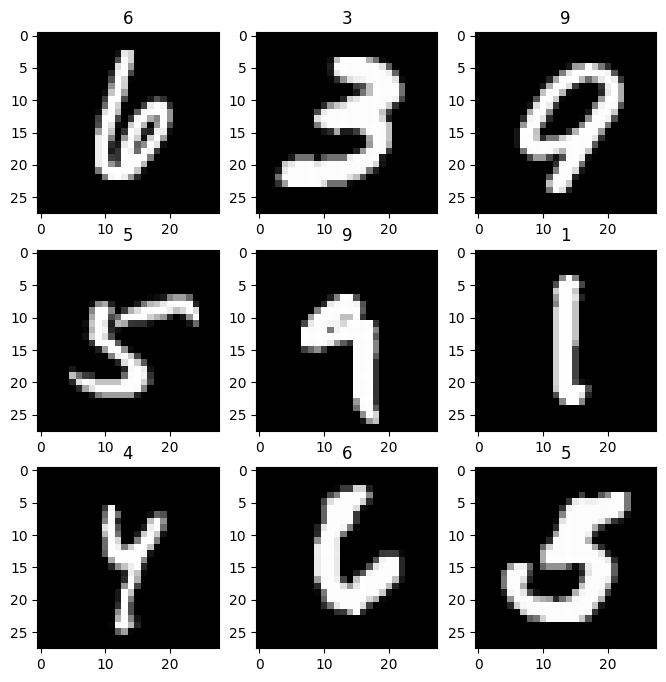

In [4]:
# data 시각화
import torch
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(train_data), size=(1, )).item()
  feature, label = train_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.imshow(feature.squeeze(), cmap='gray')

plt.show()

# PyTorch Modelint
- 파이토치는 대부분 서브 클래싱을 활용한 모델링을 수행
  - torch.nn.Module 클래스를 상속받아 만든다.
- 필수적으로 오버라이딩 할 메소드는 __init__, 순전파를 담당하는 forward

In [5]:
from torch import nn #딥러닝에 필요한 레이어 패키지

class NeuralNetwork(nn.Module):

  # 사용할 레이어 또는 블록을 정의하는 공간
  def __init__(self):
    super(NeuralNetwork, self).__init__()

    self.flatten = nn.Flatten()

    #여러 레이어가 하나의 단위로 묶이는 블록을 만들기 위해서 sequential 사용
    self.linear_relu_stack = nn.Sequential(
        #nn.Linear : Fully Connected 구조. Keras의 Dense와 같다.
        nn.Linear(in_features=28*28, out_features=128), #왜 128이 되나?
        nn.ReLU(),
        nn.Dropout(0.2), #과대 적합 방지 #훈련 시 마다 랜덤하게 20%의 가중치를 0으로 설정하여 사용하지 않는다.
        nn.Linear(128, 10) #출력층, softmax를 지정하지 않음(loss function에 포함되어 있다.) / 128 = 입력에서 나온 값
    )

  def forward(self, x): #순전파 하려면 x를 넣어 흘려줘야함
    x = self.flatten(x)
    y = self.linear_relu_stack(x)

    return y


# 모델 생성
파이토치를 활용해 모델 객체를 만들고 나서 어떤 장치 환경에서 훈련이나 추론을 할지 결정을 해줘야 한다.


In [7]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

cuda 가 출력되면 GPU 사용이 가능한 상태

In [8]:
model = NeuralNetwork().to(device) #CPU에서 만들어진 모델을 GPU로 옮긴다
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [9]:
# 또는 cuda() 메소드를 활용할 수 있다.
model2 = NeuralNetwork().cuda()
print(model2)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Output Feature Map Size
- $i$ : 입력 feature의 개수
- $o$ : 출력 feature의 수
- $k$ : kernel size
- $p$ : padding size
- $s$ : stride size

$$
o = \bigg(\frac{i+2p-k}{s}\bigg)+1
$$

실수 형태로 크기가 나오면 반드시 정수형태로 바꿔줍니다.

### 예시
- $i$ : 입력 feature의 개수 → 7
- $o$ : 출력 feature의 수 
- $k$ : kernel size → 3
- $p$ : padding size → 0
- $s$ : stride size → 1

$$
o=\bigg(\frac{7+2\times 0-3}{1}\bigg)+1=5
$$

In [29]:
class CustomConvNet(nn.Module):

  def __init__(self):
    super(CustomConvNet, self).__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1), #Cin Cout Kh,Kw
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) #입력 특성맵의 세로 가로 크기가 절반이 된다. -> 14 x 14

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1), #Cin Cout Kh,Kw
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) #7*7 #32채널

    #FCL 구현
    self.classifier = nn.Sequential(
        nn.Linear(32*7*7, 512), #뉴런개수:512
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
        
    )

    #블록들을 x 로 받아서 지금까지 만들었던 레이어를 통과시켜줌
  def forward(self, x):
    x = self.conv_block1(x)
    x = self.maxpool1(x)

    x = self.conv_block2(x)
    x = self.maxpool2(x)

    #FCL
    x = nn.Flatten()(x)
    y = self.classifier(x)

    return y

In [30]:
cnn_model = CustomConvNet().to(device)
print(cnn_model)

CustomConvNet(
  (conv_block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Linear(in_features=1568, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


데이터 로더 생성

In [31]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False) #  테스트 데이터는 굳이 섞을 필요가 없음. 성능만 볼 것

하이퍼 파라미터 선정

In [32]:
EPOCH = 10
LEARNING_RATE = 1e-3

In [33]:
#Loss Function & Optimizer
loss_fn = nn.CrossEntropyLoss() #sparse_categorical_crossentropy + categorical_crossentropy , softmax가 포함되어있음
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = LEARNING_RATE) #모델에서 최적화할 파라미터를 넣어줌

#model.parameters() -> 가중치, 편향, CNN입장에서는 필터 , 최적화에 의해 갱신해야 할 대상

훈련, 테스트 루틴 정의


In [34]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)

  #모델을 훈련 모드로 설정
  model.train() # 가중치, 편향 등을 갱신 가능

  for batch, (X, y) in enumerate(dataloader):
    #print(batch)
    #print(X.size, y.size)
    #현재 데이터(X, y)는 CPU에 존재하는 상태, 모델은 GPU에 있음
    X,y = X.to(device), y.to(device) #데이터를 gpu로 보냄

    #예측 및 손실함수 확인
    pred = model(X) #모델을 함수처럼 사용 가능 , pred = 마지막 출력층의 연산 결과
    loss = loss_fn(pred, y) #Loss가 등장, batch별 loss 값 나옴

    # 미분값 구하기 : 파이토치 에선 역전파 수행해서 구하기로 함
    optimizer.zero_grad() # 기존에 남아있던 기울기를 제거, 이전 배치의 기울기를 반영하지 않기 위함
    loss.backward() #역전파
    optimizer.step() #갱신(경사하강법(adam) 수행)

    # 배치가 100번 돌 때마다 화면에 출력
    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"Train Loss : {loss:>7f} [ {current:>5d} / {size:>5d} ]")

 #optimizer는 테스트에서 필요 없다   
def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)

  test_loss, correct = 0, 0 #여기가 accuracy가 될 것
  
  # 테스트 할 때는 평가모드(추론모드)
  model.eval()

  # 추론 과정에서는 기울기(gradient)를 구하지 않는다.
  with torch.no_grad():
    for X, y in dataloader:
      #추론 모드에서도 gpu를 활용해야 하기 때문에 데이터를 gpu환경으로 이동
      X, y = X.to(device), y.to(device)

      pred = model(X)
      test_loss += loss_fn(pred, y).item() #item(): 텐셔 내에 있는 스칼라를 가져오기
      correct += (pred.argmax(1)==y).type(torch.float).sum().item() #1: axis = 1 (방향성 주의)
      #미니배치 64장 -> 모델 -> 64장에 대한 예측 결과(10개 클래스에 대한 정보) : softmax 10개의 결과중에 확률이 가장 높은 것 뽑아줌 : 제일 높은 클래스 뽑아줌
      #배열의 인덱스가 예측한 클래스
      #argmax를 사용해서 제일 높은 값을 인덱스로 골라줌 -> 이걸 클래스로 삼아줌
      #pred.argmax(1)==y 의 결과는 true, false -> float으로 바꿔줌(typecasting) -> 이것을 다 더함

  num_batches = len(dataloader)

  #배치 별 loss 값의 평균 구하기
  test_loss /= num_batches
  correct /= size
    
  #전체 데이터의 정확도 구하기
  correct /= size
  
  print(f"Test Error : \n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {test_loss:>8f}\n")


In [21]:
#train_loop(train_dataloader, cnn_model, loss_fn, optimizer)

학습

In [35]:
epochs = 10
for t in range(epochs):
  print(f"Epoch {t+1}\n........................")
  train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
  test_loop(test_dataloader, cnn_model, loss_fn)

print("Done!")

Epoch 1
........................
Train Loss : 2.304417 [     0 / 60000 ]
Train Loss : 0.208085 [  6400 / 60000 ]
Train Loss : 0.357234 [ 12800 / 60000 ]
Train Loss : 0.072588 [ 19200 / 60000 ]
Train Loss : 0.041947 [ 25600 / 60000 ]
Train Loss : 0.023355 [ 32000 / 60000 ]
Train Loss : 0.073705 [ 38400 / 60000 ]
Train Loss : 0.074399 [ 44800 / 60000 ]
Train Loss : 0.049165 [ 51200 / 60000 ]
Train Loss : 0.154620 [ 57600 / 60000 ]
Test Error : 
 Accuracy : 0.0%, Avg Loss : 0.052740

Epoch 2
........................
Train Loss : 0.006085 [     0 / 60000 ]
Train Loss : 0.031868 [  6400 / 60000 ]
Train Loss : 0.093560 [ 12800 / 60000 ]
Train Loss : 0.026712 [ 19200 / 60000 ]
Train Loss : 0.154660 [ 25600 / 60000 ]
Train Loss : 0.030720 [ 32000 / 60000 ]
Train Loss : 0.041518 [ 38400 / 60000 ]
Train Loss : 0.009763 [ 44800 / 60000 ]
Train Loss : 0.023050 [ 51200 / 60000 ]
Train Loss : 0.012098 [ 57600 / 60000 ]
Test Error : 
 Accuracy : 0.0%, Avg Loss : 0.031806

Epoch 3
....................